### Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from scipy.spatial.distance import cdist
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from sklearn import preprocessing

import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats
from scipy.stats import pearsonr
import scipy.cluster.hierarchy as shc

import pylab 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

pd.set_option('display.float_format',lambda x: '%.5f' %x)

import warnings
warnings.filterwarnings("ignore")

### Load the dataset

In [2]:
# # Load the datasets for 2019 data
# data2019 = pd.read_csv(r'C:\Users\abandyopadhyay\ALOKPARNA\RCV_SLOTTING\Dataset\Slotting_2019.csv', header=0, encoding = 'unicode_escape')
# print("----- Feature Set ----- \n", list(data2019.columns))

# data2019 = data2019.fillna(0)

# Load the datasets for 2018 data
data2019 = pd.read_csv(r'C:\Users\abandyopadhyay\ALOKPARNA\RCV_SLOTTING\Dataset\Slotting_2018.csv', header=0, encoding = 'unicode_escape')
print("----- Feature Set ----- \n", list(data2019.columns))

this_year = 2018

data2019 = data2019.fillna(0)

----- Feature Set ----- 
 ['UniqueId', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'Season_SKU_Introduced', 'Year_SKU_Introduced', 'History_Size_Pct', 'Month', 'Season', 'Year', 'Quarter', 'PlannedUnits', 'PDXPlannedUnits', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume', 'Experiment_Id']


### Function Definitions

In [3]:
# Function to identify whether a product is new or not and add that as a feature in the dataset
def add_new_product(data):
    data.loc[(data.Year_SKU_Introduced < this_year) | ((data['Year_SKU_Introduced']).isnull()), 'NewProduct'] = '0' # Existing product
    data.loc[data.Year_SKU_Introduced >= this_year, 'NewProduct'] = '1' # New product
    return (data)

In [4]:
# Function to add 'Demand' as a feature in the dataset
def add_demand(data):
    data.loc[data.PlannedUnits != 0, 'Demand'] = data['PlannedUnits']
    data.loc[data.PlannedUnits == 0, 'Demand'] = data['PDXPlannedUnits']

    return (data)

In [5]:
# Function to Group products by Experiment Id
def group_by_expId(data):
    groupedData = data.groupby(['Experiment_Id']).agg({'Demand': 'sum', 'Orders': 'sum', 'Ordered_Units': 'sum', 'Days_Ordered': 'sum', 'Order_Volume': 'sum', 'Avg_Daily_Volume': 'mean'})
    # Remove the index and flatten the 2019 dataset
    groupedData.reset_index(inplace=True)
    print("Grouped dataset (by Experiment Id) shape: ", groupedData.shape)
    return (groupedData)

In [6]:
# Function to Group products by Experiment Id and Seasons
def group_by_Seasons(data):
    groupedData = data.groupby(['Experiment_Id', 'Season']).agg({'Demand': 'sum', 'Orders': 'sum', 'Ordered_Units': 'sum', 'Days_Ordered': 'sum', 'Order_Volume': 'sum', 'Avg_Daily_Volume': 'mean'})
    # Remove the index and flatten the 2019 dataset
    groupedData.reset_index(inplace=True)
    print("Grouped dataset (by Experiment Id and Seasons) shape: ", groupedData.shape)
    return (groupedData)

In [7]:
# Function to Group products by Experiment Id and Categorical Descriptions
def group_by_Categoricals(data):
    groupedData = data.groupby(['Experiment_Id', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct']).agg({'Demand': 'sum', 'Orders': 'sum','Ordered_Units': 'sum', 'Avg_Daily_Ordered_Units': 'mean', 'Days_Ordered': 'sum', 'Order_Volume': 'sum', 'Avg_Daily_Volume': 'mean'})
    # Remove index and flatten the dataset
    groupedData.reset_index(inplace=True)
    print("Grouped dataset (Experiment Id and Categoricals) shape: ", groupedData.shape)
    return (groupedData)

In [8]:
# Function to Group products by Experiment Id, Seasons and Categorical Descriptions
def group_by_SeasonsAndCategoricals(data):
    groupedData = data.groupby(['Experiment_Id', 'Season', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct']).agg({'Demand': 'sum', 'Orders': 'sum','Ordered_Units': 'sum', 'Avg_Daily_Ordered_Units': 'mean', 'Days_Ordered': 'sum', 'Order_Volume': 'sum', 'Avg_Daily_Volume': 'mean'})
    # Remove index and flatten the dataset
    groupedData.reset_index(inplace=True)
    print("\nGrouped dataset (Experiment Id, Seasons and Categoricals) shape: ", groupedData.shape)
    return (groupedData)

In [9]:
# Function to select the Top80 selling products
def get_Top80(data):
    # Calculate % Ordered_Units 
    totalOrdUnits = data['Ordered_Units'].sum()
    data['Pct_OrdUnits'] = (data['Ordered_Units']/totalOrdUnits)*100

    # Sort the dataset based on % Ordered_Units 
    data = data.sort_values('Pct_OrdUnits',ascending=False)
    data['Cumsum_Pct_OrdUnits'] = data['Pct_OrdUnits'].cumsum()

    # Find the orders with Top 80 sales (ordered units)
    dataTop80 = data[data.Cumsum_Pct_OrdUnits <= 80]

    # Drop the Pct_OrdUnits and Cumsum_Pct_OrdUnits columns
    dataTop80 = dataTop80.drop(['Pct_OrdUnits', 'Cumsum_Pct_OrdUnits'], axis=1)

    print("Dataset shape after retaining the Top80 selling products: ", dataTop80.shape)
    return (dataTop80)

In [10]:
# Function for K-Means clustering
def KMeans_clusterLabels(data, n):# Cluster data using k-means and get the cluster labels
    model = KMeans(n_clusters=n, random_state=1)
    model.fit(data)
    model2019 = model.predict(data)
    # Get cluster labels
    cluster_label = model.labels_
    #Plot the clusters
    plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=model2019, s=50, cmap='viridis')
    centers = model.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
    
    # Recoding the Cluster '0' as Cluster 'n'
    for i in range(len(cluster_label)): 
        if cluster_label[i] == 0:
            cluster_label[i] = n
    
    return (cluster_label)

In [11]:
# Function for Agglomerative clustering
def Agglomerative_clusterLabels(data_scaled, n):# Cluster data using k-means and get the cluster labels
    model = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    model.fit_predict(data_scaled)
    # Get cluster labels
    cluster_label = model.labels_
    #Plot the clusters
    plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=cluster_label, s=50, cmap='viridis')

    # Recoding the Cluster '0' as Cluster 'n'
    for i in range(len(cluster_label)): 
        if cluster_label[i] == 0:
            cluster_label[i] = n
    
    return (cluster_label)

In [12]:
# Function for adding binary values for ClusterLabels
def add_binary_response_Kmeans_clusterLabels(data):
    data.loc[data.KMeans_Cluster3_Label == 1, 'Cluster_1'] = '1'
    data.loc[data.KMeans_Cluster3_Label != 1, 'Cluster_1'] = '0'
    
    data.loc[data.KMeans_Cluster3_Label == 2, 'Cluster_2'] = '1'
    data.loc[data.KMeans_Cluster3_Label != 2, 'Cluster_2'] = '0'
    
    data.loc[data.KMeans_Cluster3_Label == 3, 'Cluster_3'] = '1'
    data.loc[data.KMeans_Cluster3_Label != 3, 'Cluster_3'] = '0'
    
    return (data)

In [13]:
# Function for creating Classification Dataset
def create_Classification_Dataset(data):
    # Add the new feature 'Suggested_Storage_Type' and the target 'Class' based on the 'Avg_Daily_Volume'
    data.loc[data.Avg_Daily_Volume <= 4216.22, 'Suggested_Storage_Type'] = 'Flat Rack'
    data.loc[data.Avg_Daily_Volume <= 4216.22, 'Class'] = '1'
    data.loc[(data.Avg_Daily_Volume > 4216.22) & (data.Avg_Daily_Volume <= 21081.6), 'Suggested_Storage_Type'] = 'Flow Rack' 
    data.loc[(data.Avg_Daily_Volume > 4216.22) & (data.Avg_Daily_Volume <= 21081.6), 'Class'] = '2' 
    data.loc[data.Avg_Daily_Volume > 21081.6, 'Suggested_Storage_Type'] = 'Big Pack'
    data.loc[data.Avg_Daily_Volume > 21081.6, 'Class'] = '3'

    return (data)

In [14]:
# Function to calculate Pearson Co-edfficient and p-values of a matrix
def corrcoef_loop(matrix):
    rows, cols = matrix.shape[0], matrix.shape[1]
    r = np.ones(shape=(rows, rows))
    p = np.ones(shape=(rows, rows))
    for i in range(rows):
        for j in range(i+1, rows):
            r_, p_ = pearsonr(matrix[i], matrix[j])
            r[i, j] = r[j, i] = r_
            p[i, j] = p[j, i] = p_
    return r, p

### Dataset ETL and Selection of Top80 Sales

In [15]:
# Remove those Data for which there are no Orders
dfOrders2019 = data2019[data2019.Orders != 0]

# Add a new feature to identify whether a product is New or Existing
dfOrders2019 = add_new_product(dfOrders2019)
print("0: Existing Product; 1: New Product")
print(dfOrders2019['NewProduct'].value_counts())

# Add a new feature 'Demand'
dfOrders2019 = add_demand(dfOrders2019)

# # Group 2019 dataset by Experiment_Id
# grouped2019 = group_by_expId(dfOrders2019)

# # Group 2019 dataset by Experiment_Id and Seasons
# groupedSeasons2019 = group_by_Seasons(dfOrders2019)
# groupedSpring2019 = groupedSeasons2019.loc[groupedSeasons2019['Season'] == 0].drop(['Season'], axis=1)
# groupedFall2019 = groupedSeasons2019.loc[groupedSeasons2019['Season'] == 1].drop(['Season'], axis=1)
# print("Spring2019 dataset shape: ", groupedSpring2019.shape)
# print("Fall2019 dataset shape: ", groupedFall2019.shape)

# # Group 2019 dataset by Experiment_Id and Categorical Descriptions
# groupedCat2019 = group_by_Categoricals(dfOrders2019)

# Group 2019 dataset by Experiment_Id, Seasons and Categoricals
groupedCatSeasons2019 = group_by_SeasonsAndCategoricals(dfOrders2019)

groupedCatSpring2019 = groupedCatSeasons2019.loc[groupedCatSeasons2019['Season'] == 0].drop(['Season'], axis=1)
groupedCatFall2019 = groupedCatSeasons2019.loc[groupedCatSeasons2019['Season'] == 1].drop(['Season'], axis=1)
print("Spring2019 with categorical dataset shape: ", groupedCatSpring2019.shape)
print("Fall2019 with categorical dataset shape: ", groupedCatFall2019.shape)

# Get Top80 most sold products
# df2019_Top80 = get_Top80(grouped2019)
# dfSpring2019_Top80 = get_Top80(groupedSpring2019)
# dfFall2019_Top80 = get_Top80(groupedFall2019)

# dfCat2019_Top80 = get_Top80(groupedCat2019)
dfCatSpring2019_Top80 = get_Top80(groupedCatSpring2019)
dfCatFall2019_Top80 = get_Top80(groupedCatFall2019)

print("\n----- Feature Set : dfCatSpring2019_Top80 ----- \n", list(dfCatSpring2019_Top80.columns))
print("\n----- Feature Set : dfCatFall2019_Top80 ----- \n", list(dfCatFall2019_Top80.columns))

0: Existing Product; 1: New Product
0    131966
1     25081
Name: NewProduct, dtype: int64

Grouped dataset (Experiment Id, Seasons and Categoricals) shape:  (33005, 21)
Spring2019 with categorical dataset shape:  (15050, 20)
Fall2019 with categorical dataset shape:  (17955, 20)
Dataset shape after retaining the Top80 selling products:  (2280, 20)
Dataset shape after retaining the Top80 selling products:  (2548, 20)

----- Feature Set : dfCatSpring2019_Top80 ----- 
 ['Experiment_Id', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct', 'Demand', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume']

----- Feature Set : dfCatFall2019_Top80 ----- 
 ['Experiment_Id', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct', 'Demand', 'Orders', 'Ordered

In [16]:
# # Cluster 2019 dataset (without categorical descriptions) by K-Means Clustering
# df2019_Top80_kmeans = df2019_Top80.copy()

# # Add the cluster labels to the dataset
# # Number of clusters : 3
# cluster3_label = KMeans_clusterLabels(df2019_Top80, 3)
# df2019_Top80_kmeans['Cluster3_Label'] = cluster3_label

# print("\n----- 2019 Cluster_Label counts -----")
# print(df2019_Top80_kmeans['Cluster3_Label'].value_counts())

In [17]:
# # Number of clusters : 4
# cluster4_label = KMeans_clusterLabels(df2019_Top80, 4)
# df2019_Top80_kmeans['Cluster4_Label'] = cluster4_label

# print("\n----- 2019 Cluster_Label counts -----")
# print(df2019_Top80_kmeans['Cluster4_Label'].value_counts())

In [18]:
# # Remove the order details and retain only the cluster labels along with the Experiment_Id
# df2019_Top80_kmeans_labels = df2019_Top80_kmeans.drop(['Demand', 'Orders', 'Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume'], axis=1)
# print("Dataset shape: ", df2019_Top80_kmeans_labels.shape)

# # Clustering Accuracy : Calculate Silhouette Coefficient
# # Evaluate the 3-cluster model
# accuracyCluster3 = silhouette_score(df2019_Top80, cluster3_label)
# print("Accuracy of kmeans with n=3: ", accuracyCluster3)
# # Evaluate the 4-cluster model
# accuracyCluster4 = silhouette_score(df2019_Top80, cluster4_label)
# print("Accuracy of kmeans with n=4: ", accuracyCluster4)

### Feature Selection for Clustering

In [19]:
CLUSTERING_FEATURE_SET_1 = ['Volume', 'Orders', 'Ordered_Units', 'Days_Ordered', 'Order_Volume']
CLUSTERING_FEATURE_SET_2 = ['Volume', 'Orders', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume']
CLUSTERING_FEATURE_SET_3 = ['Volume', 'Orders', 'Ordered_Units', 'Days_Ordered', 'Avg_Daily_Volume']
CLUSTERING_FEATURE_SET_4 = ['Volume', 'Orders', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Avg_Daily_Volume']

CLUSTERING_FEATURE_SET = CLUSTERING_FEATURE_SET_4

dfSpring2019_Top80_kmeans = dfCatSpring2019_Top80[CLUSTERING_FEATURE_SET]
dfFall2019_Top80_kmeans = dfCatFall2019_Top80[CLUSTERING_FEATURE_SET]

In [20]:
dataSpring = dfCatSpring2019_Top80[['Volume', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume']]

# Data normalization
data_normed_Spring = normalize(dataSpring)
data_normed_Spring = pd.DataFrame(data_normed_Spring, columns=dataSpring.columns)

# Data Standard Scaler
# Create scaler
scaler = preprocessing.StandardScaler()
# Transform the feature
data_scaled_Spring = scaler.fit_transform(dataSpring)
data_scaled_Spring = pd.DataFrame(data_scaled_Spring, columns=dataSpring.columns)

In [21]:
dataFall = dfCatFall2019_Top80[['Volume', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume']]

# Data normalization
data_normed_Fall = normalize(dataFall)
data_normed_Fall = pd.DataFrame(data_normed_Fall, columns=dataFall.columns)

# Data Standard Scaler
# Create scaler
scaler = preprocessing.StandardScaler()
# Transform the feature
data_scaled_Fall = scaler.fit_transform(dataFall)
data_scaled_Fall = pd.DataFrame(data_scaled_Fall, columns=dataFall.columns)

In [22]:
def plot_Histograms(data):
    fig, ax = plt.subplots(1, 2, figsize=(20,4))
    volume = data['Volume'].values
    sns.distplot(volume, ax=ax[0], color='r')
    ax[0].set_title('Distribution of Volume', fontsize=14)
    ax[0].set_xlim([min(volume), max(volume)])

    orders = data['Orders'].values
    sns.distplot(orders, ax=ax[1], color='b')
    ax[1].set_title('Distribution of Orders', fontsize=14)
    ax[1].set_xlim([min(orders), max(orders)])
    
    fig, ax = plt.subplots(1, 2, figsize=(20,4))
    ordered_Units = data['Ordered_Units'].values
    sns.distplot(ordered_Units, ax=ax[0], color='g')
    ax[0].set_title('Distribution of Ordered_Units', fontsize=14)
    ax[0].set_xlim([min(ordered_Units), max(ordered_Units)])
    
    avg_Daily_Ordered_Units = data['Avg_Daily_Ordered_Units'].values
    sns.distplot(avg_Daily_Ordered_Units, ax=ax[1], color='m')
    ax[1].set_title('Distribution of Avg_Daily_Ordered_Units', fontsize=14)
    ax[1].set_xlim([min(avg_Daily_Ordered_Units), max(avg_Daily_Ordered_Units)])
    
    fig, ax = plt.subplots(1, 2, figsize=(20,4))
    days_Ordered = data['Days_Ordered'].values
    sns.distplot(days_Ordered, ax=ax[0], color='r')
    ax[0].set_title('Distribution of Days_Ordered', fontsize=14)
    ax[0].set_xlim([min(days_Ordered), max(days_Ordered)])
    
    order_Volume = data['Order_Volume'].values
    sns.distplot(order_Volume, ax=ax[1], color='b')
    ax[1].set_title('Distribution of Order_Volume', fontsize=14)
    ax[1].set_xlim([min(order_Volume), max(order_Volume)])    
    
    fig, ax = plt.subplots(1, 2, figsize=(20,4))
    avg_Daily_Volume = data['Avg_Daily_Volume'].values
    sns.distplot(avg_Daily_Volume, ax=ax[0], color='g')
    ax[0].set_title('Distribution of Avg_Daily_Volume', fontsize=14)
    ax[0].set_xlim([min(avg_Daily_Volume), max(avg_Daily_Volume)])

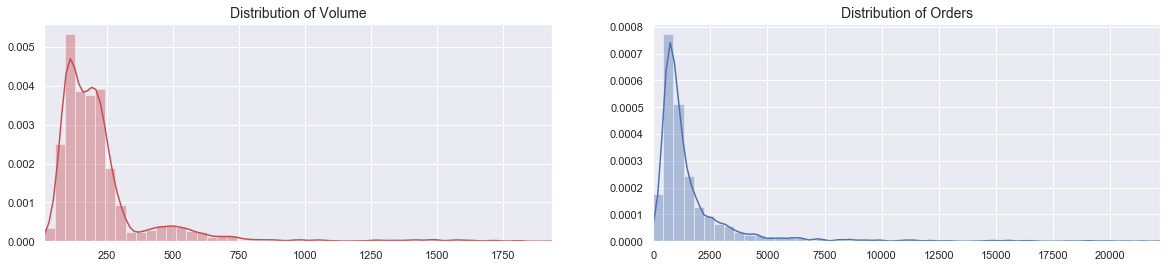

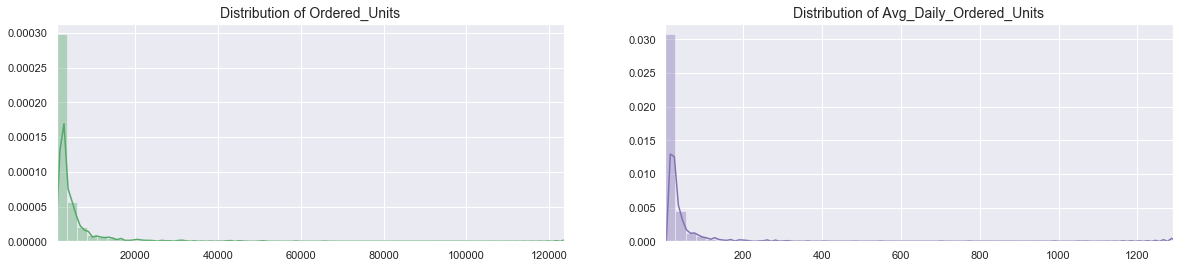

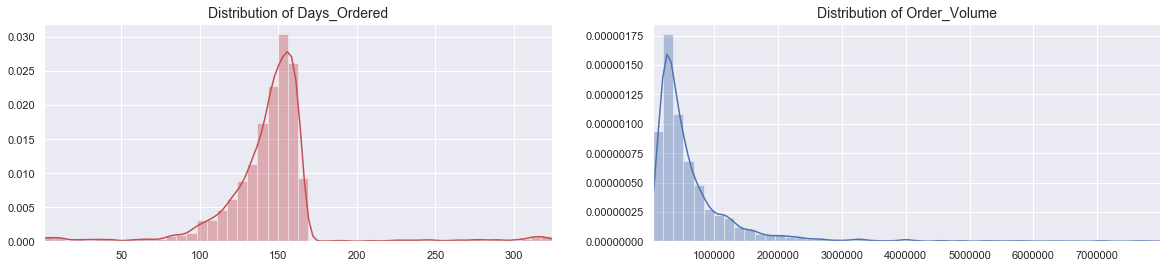

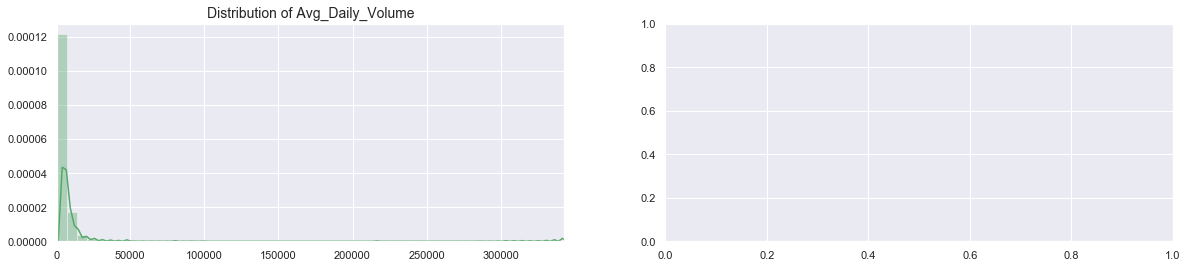

In [23]:
plot_Histograms(dataSpring)

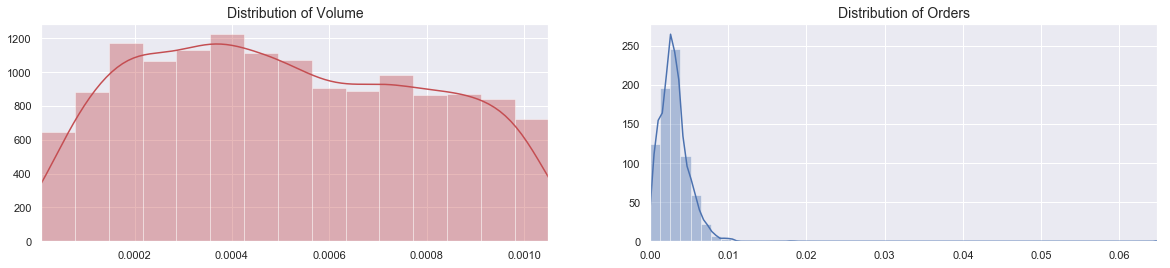

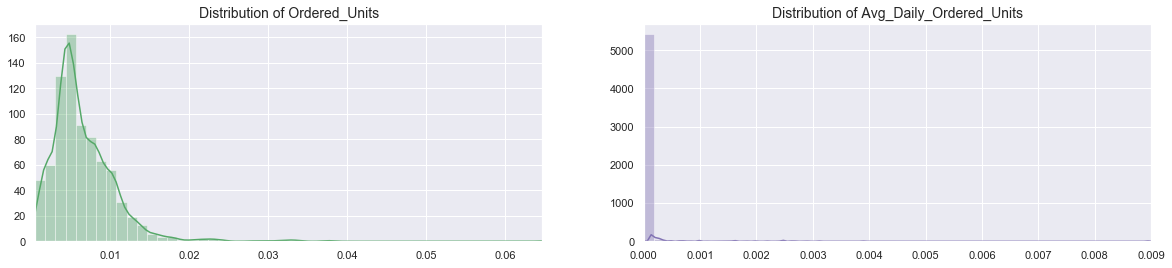

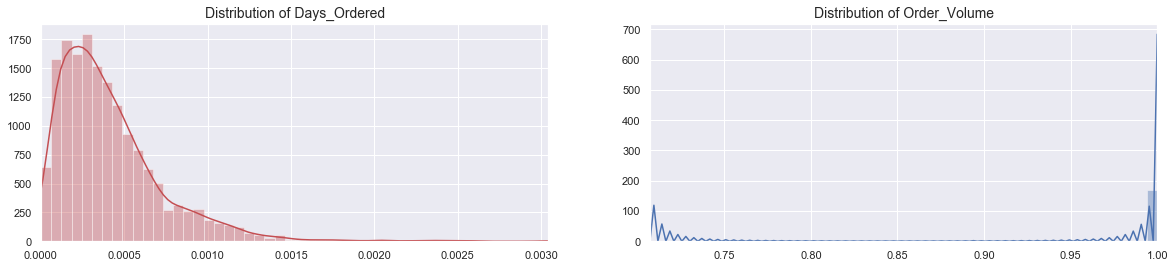

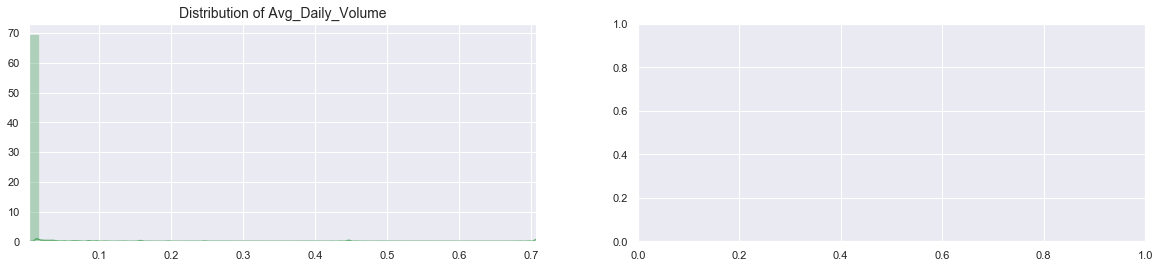

In [24]:
plot_Histograms(data_normed_Spring)

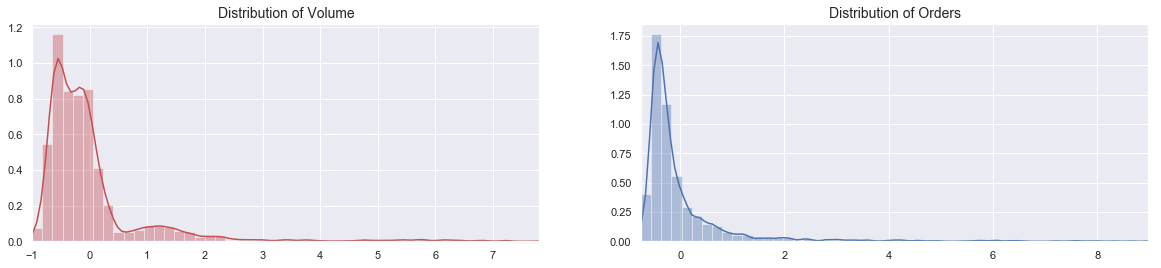

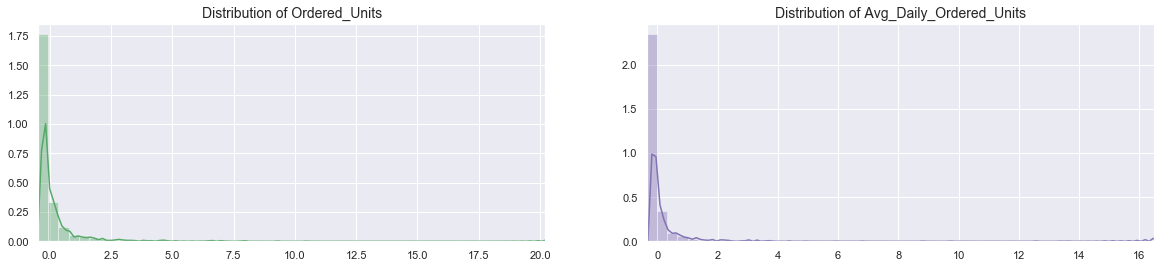

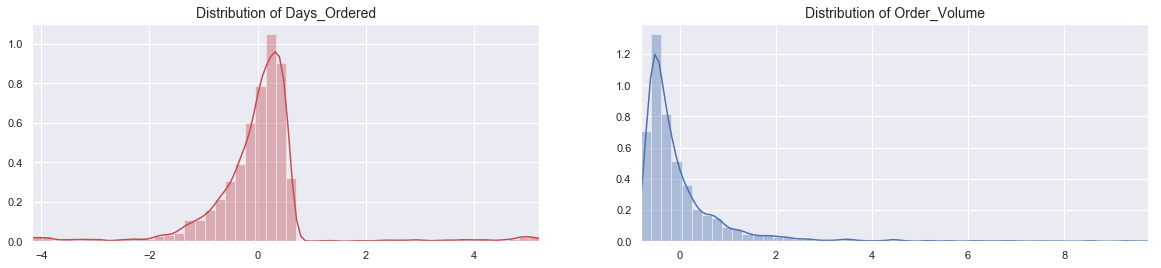

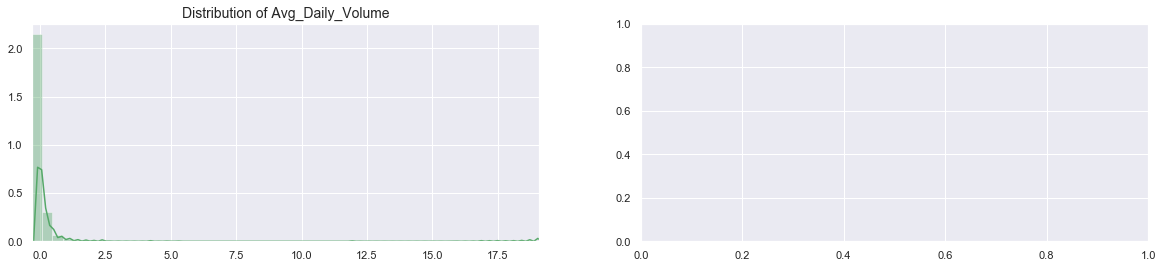

In [25]:
plot_Histograms(data_scaled_Spring)

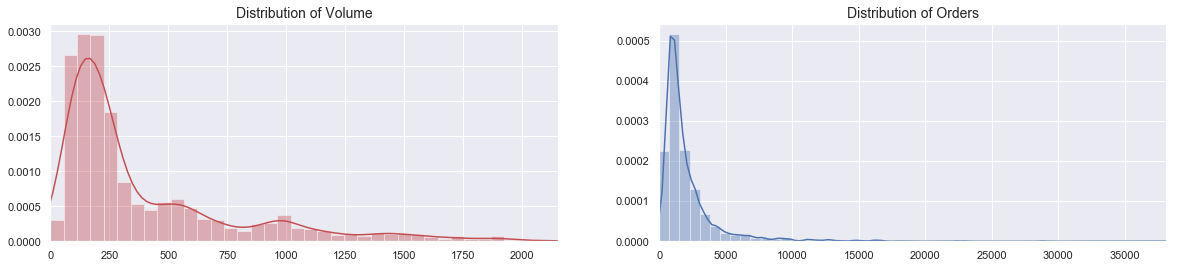

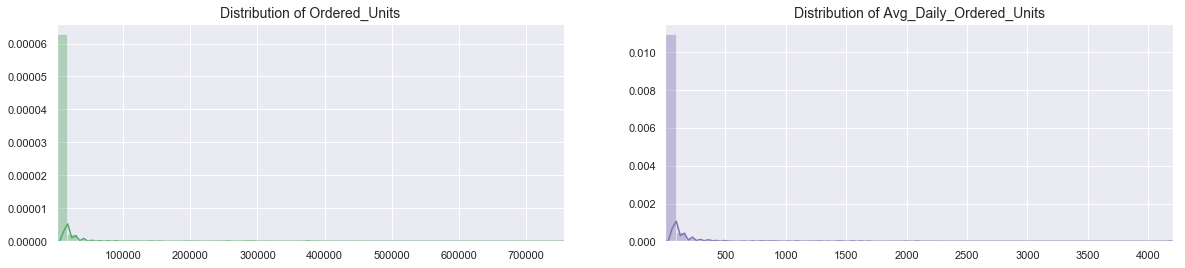

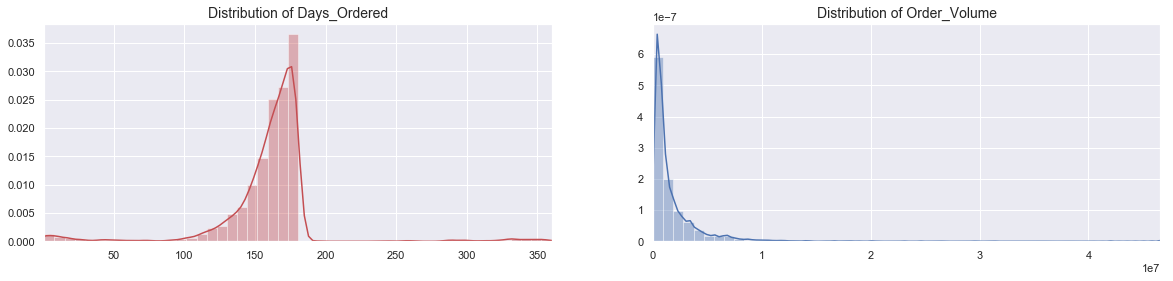

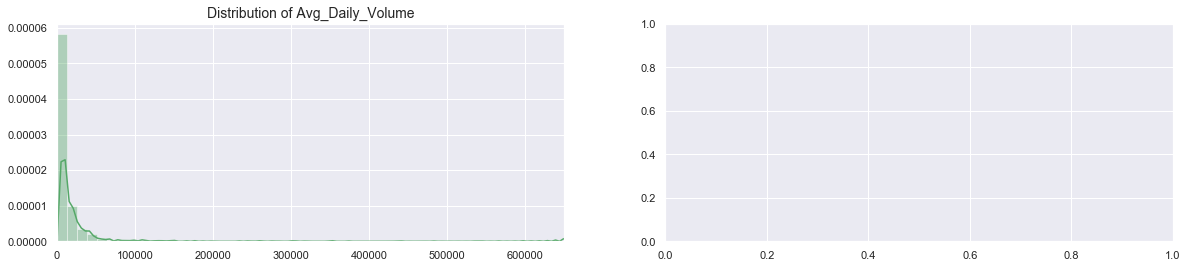

In [26]:
plot_Histograms(dataFall)

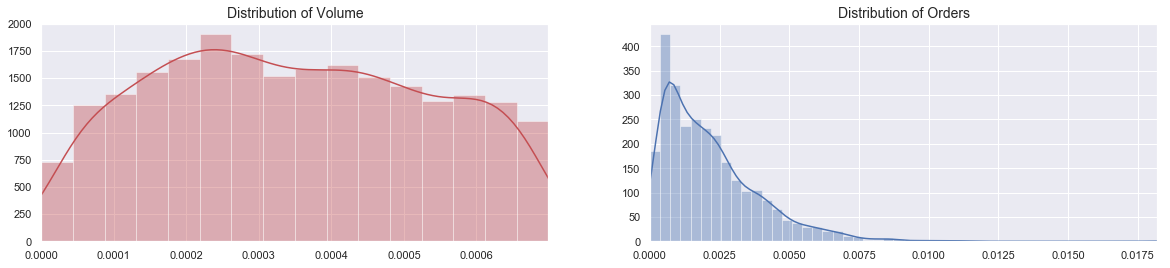

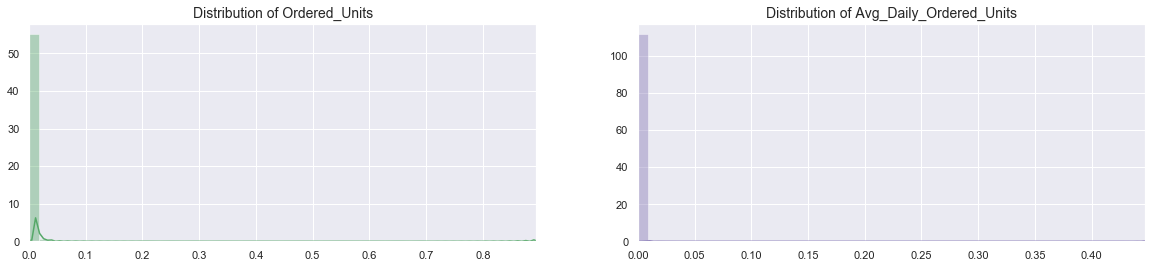

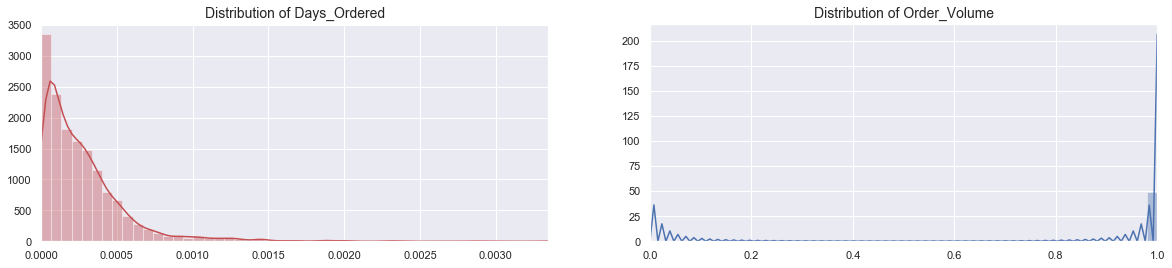

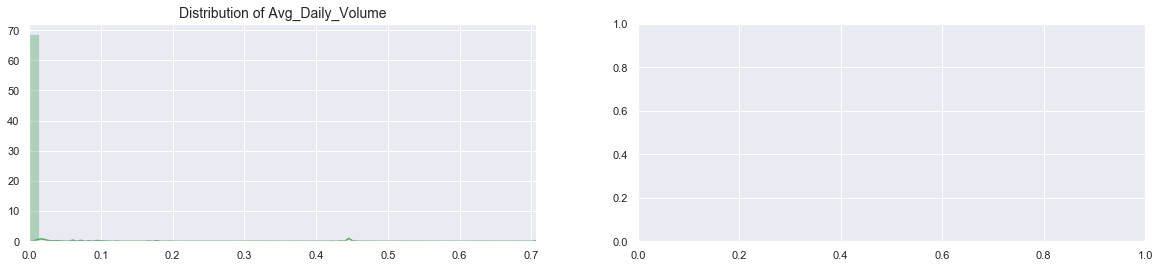

In [27]:
plot_Histograms(data_normed_Fall)

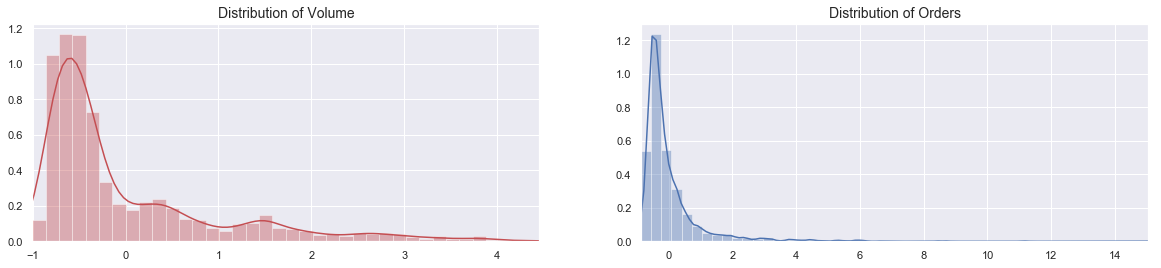

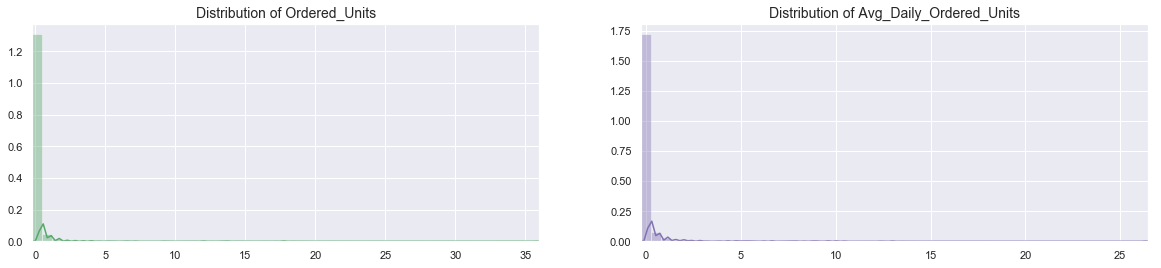

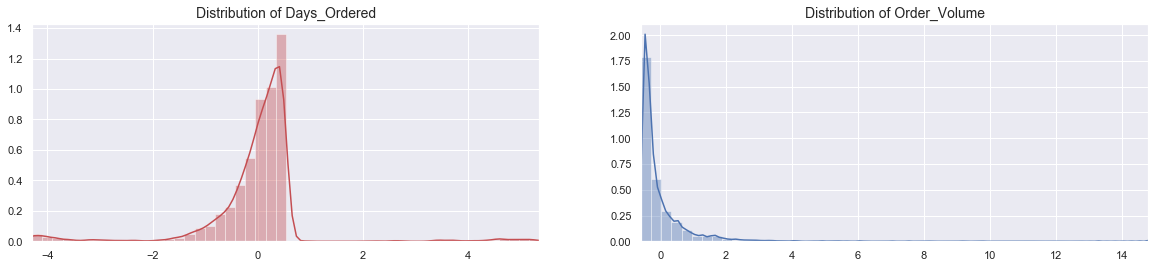

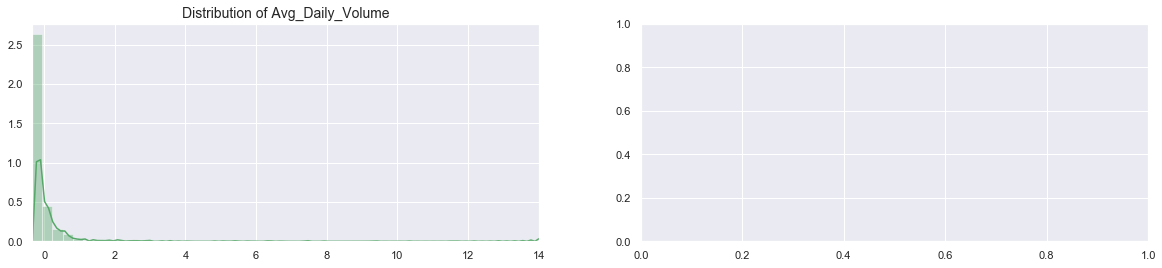

In [28]:
plot_Histograms(data_scaled_Fall)

In [44]:
def ksTest_QQPlots(data):
    print("Volume: ", stats.kstest(data['Volume'], 'norm'))
    qqplot(data['Volume'], line='s')
    plt.show()
    print("Orders: ", stats.kstest(data['Orders'], 'norm'))
    qqplot(data['Orders'], line='s')
    plt.show()
    print("Ordered_Units: ", stats.kstest(data['Ordered_Units'], 'norm'))
    qqplot(data['Ordered_Units'], line='s')
    plt.show()
    print("Avg_Daily_Ordered_Units: ", stats.kstest(data['Avg_Daily_Ordered_Units'], 'norm'))
    qqplot(data['Avg_Daily_Ordered_Units'], line='s')
    plt.show()
    print("Days_Ordered: ", stats.kstest(data['Days_Ordered'], 'norm'))
    qqplot(data['Days_Ordered'], line='s')
    plt.show()
    print("Order_Volume: ", stats.kstest(data['Order_Volume'], 'norm'))
    qqplot(data['Order_Volume'], line='s')
    plt.show()
    print("Avg_Daily_Volume: ", stats.kstest(data['Avg_Daily_Volume'], 'norm'))
    qqplot(data['Avg_Daily_Volume'], line='s')
    plt.show()

Volume:  KstestResult(statistic=1.0, pvalue=0.0)


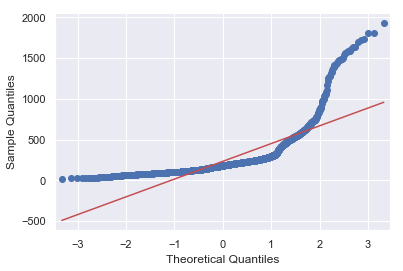

Orders:  KstestResult(statistic=0.9960209603371143, pvalue=0.0)


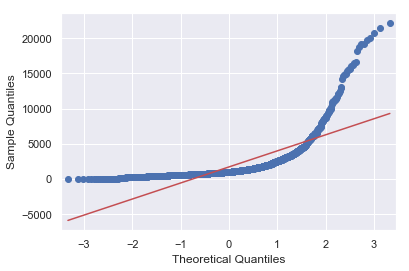

Ordered_Units:  KstestResult(statistic=1.0, pvalue=0.0)


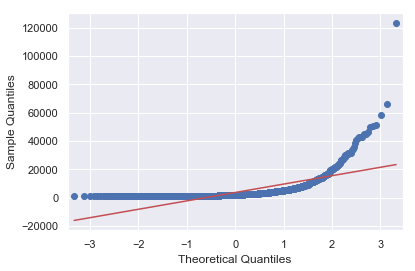

Avg_Daily_Ordered_Units:  KstestResult(statistic=0.9995709396668032, pvalue=0.0)


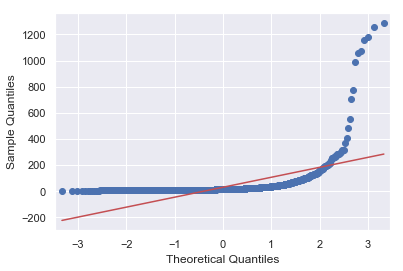

Days_Ordered:  KstestResult(statistic=0.9956140341011316, pvalue=0.0)


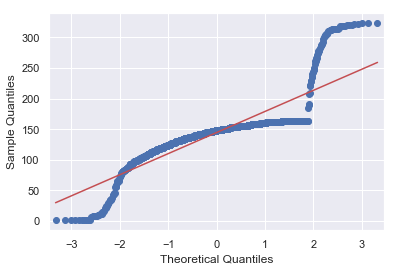

Order_Volume:  KstestResult(statistic=1.0, pvalue=0.0)


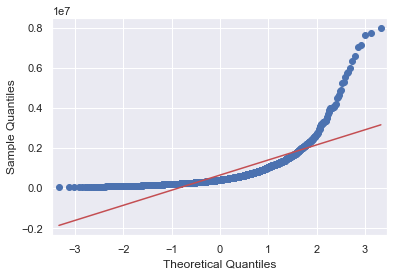

Avg_Daily_Volume:  KstestResult(statistic=1.0, pvalue=0.0)


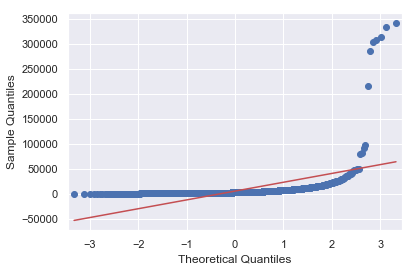

In [45]:
ksTest_QQPlots(dataSpring)

Volume:  KstestResult(statistic=0.5000032291844757, pvalue=0.0)


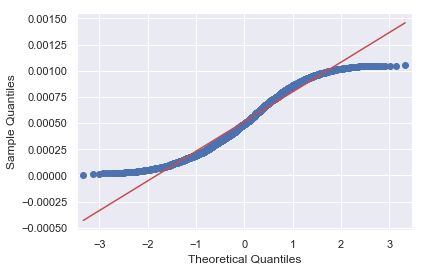

Orders:  KstestResult(statistic=0.5000008443876882, pvalue=0.0)


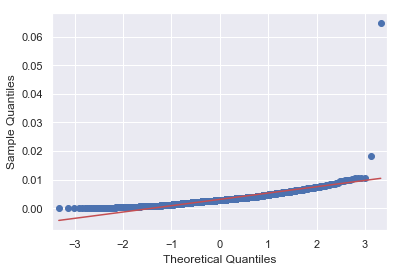

Ordered_Units:  KstestResult(statistic=0.5002064070446367, pvalue=0.0)


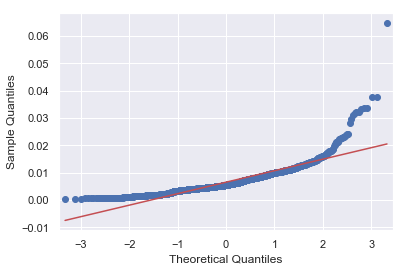

Avg_Daily_Ordered_Units:  KstestResult(statistic=0.5000015261432936, pvalue=0.0)


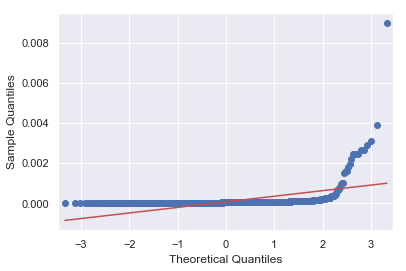

Days_Ordered:  KstestResult(statistic=0.5000008232078605, pvalue=0.0)


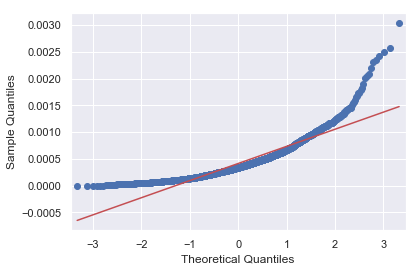

Order_Volume:  KstestResult(statistic=0.8330205984555517, pvalue=0.0)


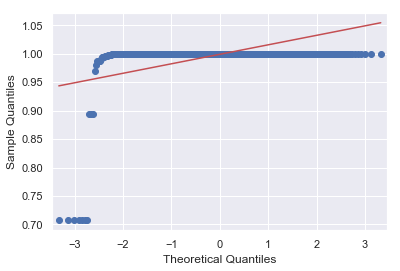

Avg_Daily_Volume:  KstestResult(statistic=0.5012135018762501, pvalue=0.0)


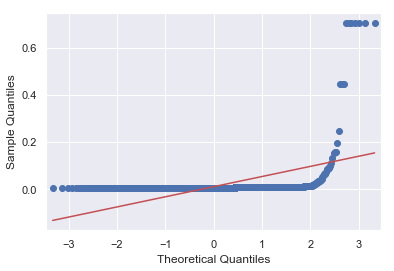

In [46]:
ksTest_QQPlots(data_normed_Spring)

Volume:  KstestResult(statistic=0.24210239944822054, pvalue=4.006848024292054e-118)


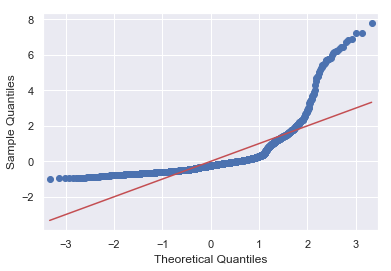

Orders:  KstestResult(statistic=0.24607559929929335, pvalue=4.5073817326618866e-122)


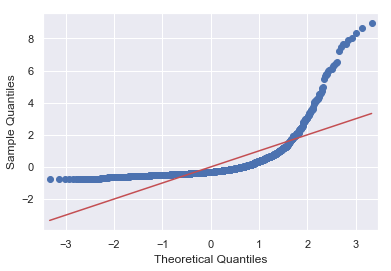

Ordered_Units:  KstestResult(statistic=0.3198118423905871, pvalue=6.296305014723017e-208)


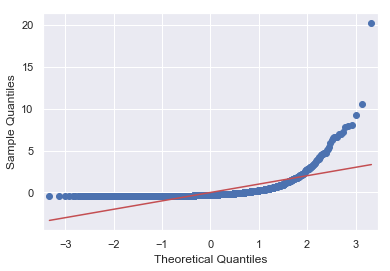

Avg_Daily_Ordered_Units:  KstestResult(statistic=0.3684314406363884, pvalue=4.3536346894504175e-278)


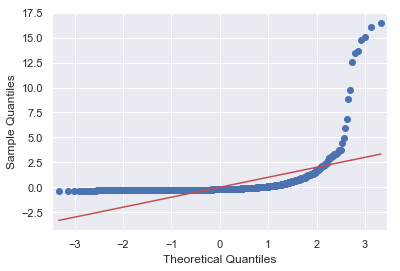

Days_Ordered:  KstestResult(statistic=0.2571925002372508, pvalue=1.7501814299339044e-133)


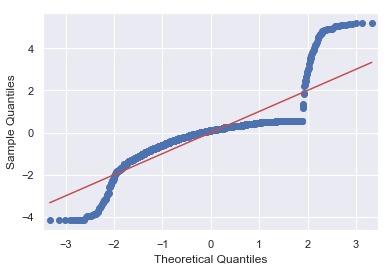

Order_Volume:  KstestResult(statistic=0.21801657387991322, pvalue=1.2475182499846903e-95)


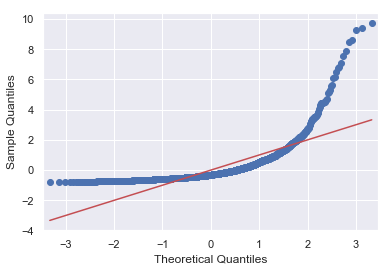

Avg_Daily_Volume:  KstestResult(statistic=0.38137534273328344, pvalue=1.1467763637512218e-298)


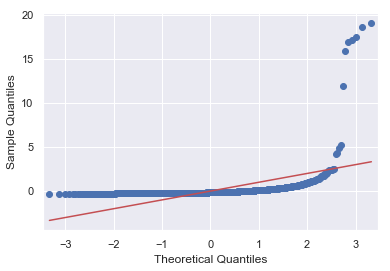

In [47]:
ksTest_QQPlots(data_scaled_Spring)

Volume:  KstestResult(statistic=0.999607535321821, pvalue=0.0)


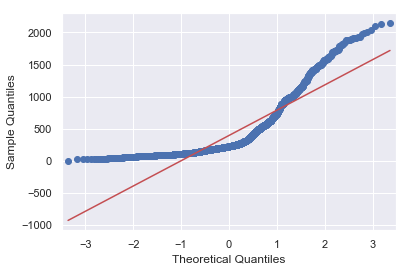

Orders:  KstestResult(statistic=0.9948662879418404, pvalue=0.0)


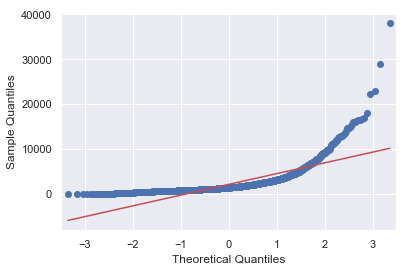

Ordered_Units:  KstestResult(statistic=1.0, pvalue=0.0)


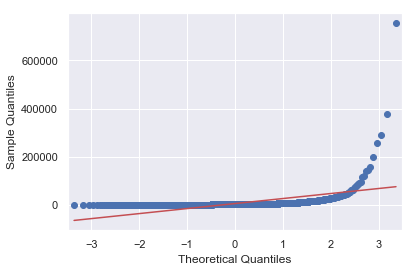

Avg_Daily_Ordered_Units:  KstestResult(statistic=0.9999984693732634, pvalue=0.0)


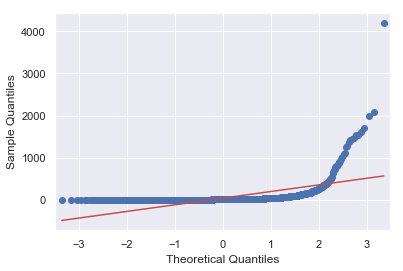

Days_Ordered:  KstestResult(statistic=0.9929353491412067, pvalue=0.0)


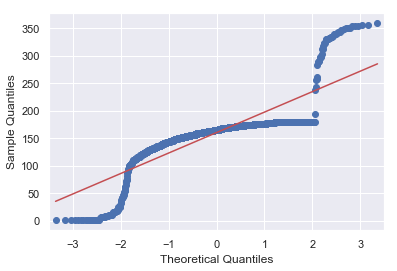

Order_Volume:  KstestResult(statistic=0.999607535321821, pvalue=0.0)


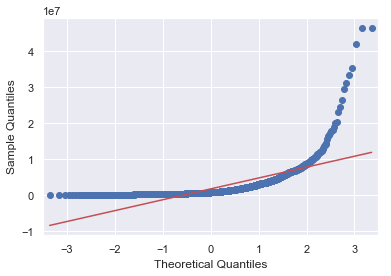

Avg_Daily_Volume:  KstestResult(statistic=0.999607535321821, pvalue=0.0)


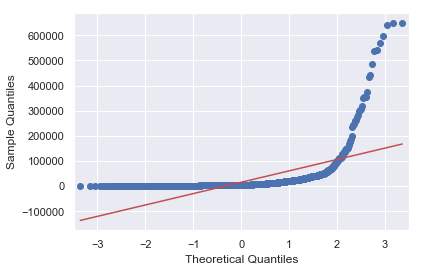

In [48]:
ksTest_QQPlots(dataFall)

Volume:  KstestResult(statistic=0.5, pvalue=0.0)


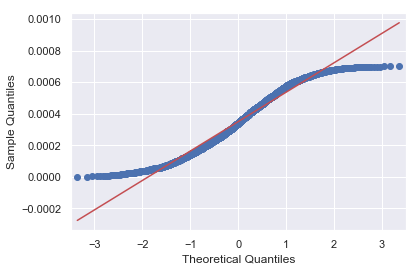

Orders:  KstestResult(statistic=0.5000017677509941, pvalue=0.0)


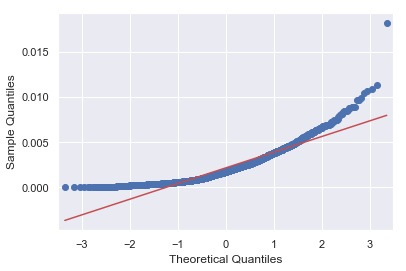

Ordered_Units:  KstestResult(statistic=0.5001853860143868, pvalue=0.0)


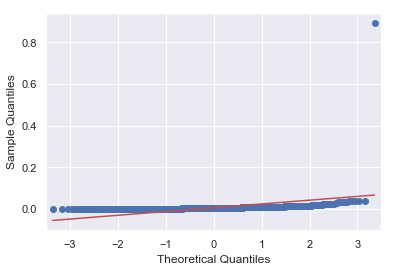

Avg_Daily_Ordered_Units:  KstestResult(statistic=0.5000008254819578, pvalue=0.0)


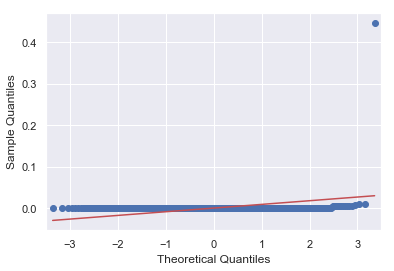

Days_Ordered:  KstestResult(statistic=0.5000005719982571, pvalue=0.0)


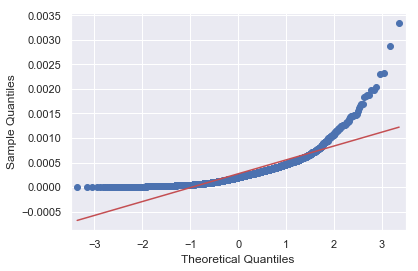

Order_Volume:  KstestResult(statistic=0.8301287005875855, pvalue=0.0)


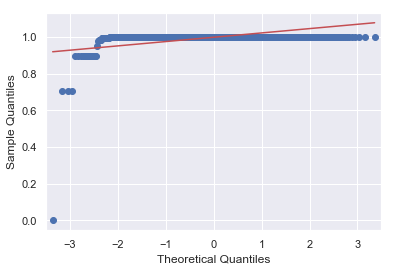

Avg_Daily_Volume:  KstestResult(statistic=0.5007193843572744, pvalue=0.0)


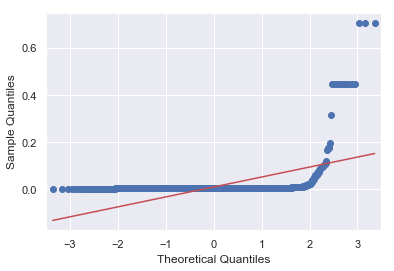

In [49]:
ksTest_QQPlots(data_normed_Fall)

Volume:  KstestResult(statistic=0.22260515557834382, pvalue=2.1658338709189904e-111)


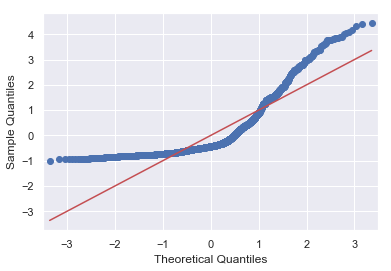

Orders:  KstestResult(statistic=0.2075620082763585, pvalue=9.260806988951452e-97)


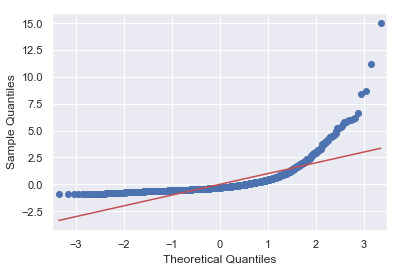

Ordered_Units:  KstestResult(statistic=0.41120887991307703, pvalue=0.0)


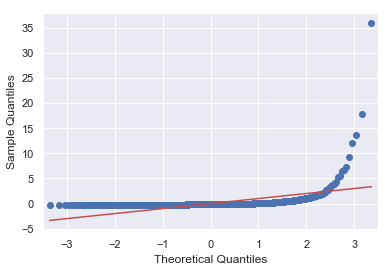

Avg_Daily_Ordered_Units:  KstestResult(statistic=0.39347531805870556, pvalue=0.0)


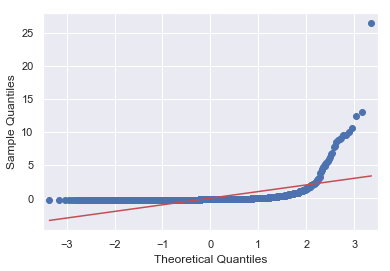

Days_Ordered:  KstestResult(statistic=0.2801162799729985, pvalue=2.6024543161786475e-177)


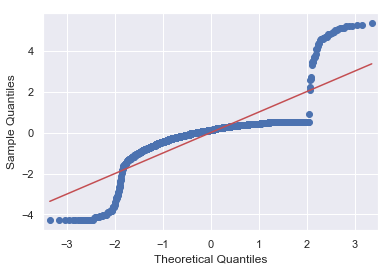

Order_Volume:  KstestResult(statistic=0.2870057616626037, pvalue=2.7306002688075684e-186)


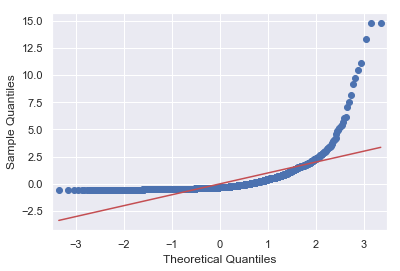

Avg_Daily_Volume:  KstestResult(statistic=0.3683421542978678, pvalue=1.46750752097893e-310)


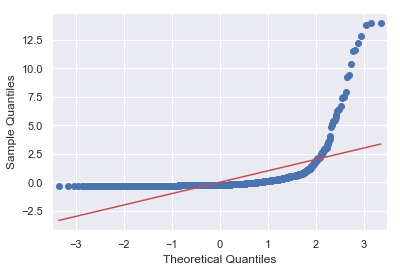

In [50]:
ksTest_QQPlots(data_scaled_Fall)

### Agglomerative Clustering

In [ ]:
data = dfSpring2019_Top80_kmeans.copy()
data_scaled = normalize(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))

In [ ]:
# Cluster Spring data by Agglomerative Clustering
# Agglomerative with n=3
cluster_label = Agglomerative_clusterLabels(data_scaled, 3)

dfCatSpring2019_Top80['Agglo_Cluster3_Label'] = cluster_label
print("\n----- Spring Cluster_Label counts with Agglomerative n=3 -----")
print(dfCatSpring2019_Top80['Agglo_Cluster3_Label'].value_counts())

# Clustering Accuracy : Calculate Silhouette Coefficient
# Evaluate the cluster model for Spring data
accuracySpring = silhouette_score(data_scaled, cluster_label)
print("Accuracy of Agglomerative with n=3 on Spring data: ", accuracySpring)

In [ ]:
data = dfFall2019_Top80_kmeans.copy()
data_scaled = normalize(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))

In [ ]:
# Cluster Fall data by Agglomerative Clustering
# Agglomerative with n=3
cluster_label = Agglomerative_clusterLabels(data_scaled, 3)

dfCatFall2019_Top80['Agglo_Cluster3_Label'] = cluster_label
print("\n----- Fall Cluster_Label counts with Agglomerative n=3 -----")
print(dfCatFall2019_Top80['Agglo_Cluster3_Label'].value_counts())

# Clustering Accuracy : Calculate Silhouette Coefficient
# Evaluate the cluster model for Fall data
accuracyFall = silhouette_score(data_scaled, cluster_label)
print("Accuracy of Agglomerative with n=3 on Fall data: ", accuracyFall)

### Calculate Corelation of Selected Features

In [ ]:
# corr_Spring = dfSpring2019_Top80_kmeans.corr()
# corr_Spring.style.background_gradient(cmap='coolwarm', axis=None)

In [ ]:
# corr_Fall = dfFall2019_Top80_kmeans.corr()
# corr_Fall.style.background_gradient(cmap='coolwarm', axis=None)

### Calculate 'p-value' of Corelation matrix

In [ ]:
# # Find p-values (p) of Spring Corelation Matrix
# r, p = corrcoef_loop(corr_Spring.values)

# # Convert the p-value matrix into a dataframe for plotting
# p_df = pd.DataFrame(p)
# p_df.columns = CLUSTERING_FEATURE_SET
# p_df.index = CLUSTERING_FEATURE_SET

# p_df.style.background_gradient(cmap='coolwarm', axis=None)

In [ ]:
# # Find p-values (p) of Fall Corelation Matrix
# r, p = corrcoef_loop(corr_Fall.values)

# # Convert the p-value matrix into a dataframe for plotting
# p_df = pd.DataFrame(p)
# p_df.columns = CLUSTERING_FEATURE_SET
# p_df.index = CLUSTERING_FEATURE_SET

# p_df.style.background_gradient(cmap='coolwarm', axis=None)

### Calculate 'Confidence Interval' of clustering dataset

In [ ]:
# # Calculate confidence interval of Spring2019 dataset
# confInt_Spring =  pd.DataFrame(sms.DescrStatsW(dfSpring2019_Top80_kmeans).tconfint_mean(),
#                                columns=CLUSTERING_FEATURE_SET)
# print('\n----- Confidence interval of Spring2019 dataset -----\n\n', confInt_Spring)

# # Calculate confidence interval of Fall2019 dataset
# confInt_Fall = pd.DataFrame(sms.DescrStatsW(dfFall2019_Top80_kmeans).tconfint_mean(),
#                             columns=CLUSTERING_FEATURE_SET)
# print('\n----- Confidence interval of Fall2019 dataset -----\n\n', confInt_Fall)

### K-Means Clustering

In [ ]:
# Cluster Spring 2019 by K-Means Clustering
# Kmeans with n=3 on Spring2019 Data
spring_cluster3_label = KMeans_clusterLabels(dfSpring2019_Top80_kmeans, 3)
dfCatSpring2019_Top80['KMeans_Cluster3_Label'] = spring_cluster3_label

print("\n----- Spring Cluster_Label counts with KMeans n=3 -----")
print(dfCatSpring2019_Top80['KMeans_Cluster3_Label'].value_counts())

# Clustering Accuracy : Calculate Silhouette Coefficient
# Evaluate the 3-cluster model for Spring2019
accuracySpring = silhouette_score(dfSpring2019_Top80_kmeans, spring_cluster3_label)
print("Accuracy of KMeans with n=3 on Spring data: ", accuracySpring)

# Add binary response values for each Cluster Labels
dfCatSpring2019_Top80 = add_binary_response_Kmeans_clusterLabels(dfCatSpring2019_Top80)

In [ ]:
# Cluster Fall 2019 by K-Means Clustering
# Kmeans with n=3 on Fall2019 Data
fall_cluster3_label = KMeans_clusterLabels(dfFall2019_Top80_kmeans, 3)
dfCatFall2019_Top80['KMeans_Cluster3_Label'] = fall_cluster3_label

print("\n----- Fall Cluster_Label counts with KMeans n=3 -----")
print(dfCatFall2019_Top80['KMeans_Cluster3_Label'].value_counts())

# Clustering Accuracy : Calculate Silhouette Coefficient
# Evaluate the 3-cluster model for Fall2019
accuracyFall = silhouette_score(dfFall2019_Top80_kmeans, fall_cluster3_label)
print("Accuracy of KMeans with n=3 on Fall data: ", accuracyFall)

# Add binary response values for each Cluster Labels
dfCatFall2019_Top80 = add_binary_response_Kmeans_clusterLabels(dfCatFall2019_Top80)

In [ ]:
# Create datasets for Classification (2019, Spring2019 and Fall2019)
# df2019 = create_Classification_Dataset(dfCat2019_Top80, df2019_Top80_kmeans_labels)
# print("2019 dataset shape: ", df2019.shape)
# print("----- Feature Set ----- \n", list(df2019.columns))

dfSpring2019 = create_Classification_Dataset(dfCatSpring2019_Top80)
print("Spring 2019 dataset shape: ", dfSpring2019.shape)
print("----- Feature Set ----- \n", list(dfSpring2019.columns))
print("\n")
dfFall2019 = create_Classification_Dataset(dfCatFall2019_Top80)
print("Fall 2019 dataset shape: ", dfFall2019.shape)
print("----- Feature Set ----- \n", list(dfFall2019.columns))

In [ ]:
sns.boxplot(x='Suggested_Storage_Type', y='Avg_Daily_Volume', data=dfSpring2019, showfliers=False)

In [ ]:
sns.boxplot(x='Agglo_Cluster3_Label', y='Avg_Daily_Volume', data=dfSpring2019, showfliers=False)

In [ ]:
sns.boxplot(x='KMeans_Cluster3_Label', y='Avg_Daily_Volume', data=dfSpring2019, showfliers=False)

In [ ]:
sns.boxplot(x='Suggested_Storage_Type', y='Avg_Daily_Volume', data=dfFall2019, showfliers=False)

In [ ]:
sns.boxplot(x='Agglo_Cluster3_Label', y='Avg_Daily_Volume', data=dfFall2019, showfliers=False)

In [ ]:
sns.boxplot(x='KMeans_Cluster3_Label', y='Avg_Daily_Volume', data=dfFall2019, showfliers=False)

### Classification - Multinomial Logistic Regression

In [ ]:
# Create one-vs-rest multinomial logistic regression object
clf = LogisticRegression(random_state=0, multi_class='ovr', solver='newton-cg')

# FEATURE_SET = ['NewProduct', 'Demand', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume']
FEATURE_SET = ['NewProduct', 'Demand', 'Ordered_Units','Order_Volume']

TARGET_CLUSTER = ['Cluster3_Label']
TARGET_CLASS = ['Class']

# SPRING DATA
spring_X = dfSpring2019[FEATURE_SET] # Spring Training Set
# spring_y1 = dfSpring2019[TARGET_CLUSTER] # Target: 3-cluster labels
spring_y2 = dfSpring2019[TARGET_CLASS]    # Target: Class (Dale's classification)
spring_cluster_y1 = dfSpring2019['Cluster_1'] # Target: Spring Cluster_1 binary response
spring_cluster_y2 = dfSpring2019['Cluster_2'] # Target: Spring Cluster_2 binary response
spring_cluster_y3 = dfSpring2019['Cluster_3'] # Target: Spring Cluster_3 binary response

# FALL DATA
fall_X = dfFall2019[FEATURE_SET] # Fall Training Set
# fall_y1 = dfFall2019[TARGET_CLUSTER] # Target: 3-cluster labels
fall_y2 = dfFall2019[TARGET_CLASS]    # Target: Class (Dale's classification)
fall_cluster_y1 = dfFall2019['Cluster_1'] # Target: Fall Cluster_1 binary response
fall_cluster_y2 = dfFall2019['Cluster_2'] # Target: Fall Cluster_2 binary response
fall_cluster_y3 = dfFall2019['Cluster_3'] # Target: Fall Cluster_3 binary response

In [ ]:
#Corelation matrix of Features: Spring Data
corr_Spring = spring_X.corr()
corr_Spring.style.background_gradient(cmap='coolwarm', axis=None)

In [ ]:
# Find p-values (p) of Spring Corelation Matrix
r, p = corrcoef_loop(corr_Spring.values)

# Convert the p-value matrix into a dataframe for plotting
p_df = pd.DataFrame(p)
# p_df.columns = FEATURE_SET
# p_df.index = FEATURE_SET

p_df.style.background_gradient(cmap='coolwarm', axis=None)

In [ ]:
#Corelation matrix of Features: Fall Data
corr_Fall = fall_X.corr()
corr_Fall.style.background_gradient(cmap='coolwarm', axis=None)

In [ ]:
# Find p-values (p) of Fall Corelation Matrix
r, p = corrcoef_loop(corr_Fall.values)

# Convert the p-value matrix into a dataframe for plotting
p_df = pd.DataFrame(p)
# p_df.columns = FEATURE_SET
# p_df.index = FEATURE_SET

p_df.style.background_gradient(cmap='coolwarm', axis=None)

#### Multinomial Logit - Fit Statistics

In [ ]:
# # Train Model and get the Fit Statistics
# # Target: Spring Cluster_1 binary response
# logit_model=sm.Logit(spring_cluster_y1.astype(float),spring_X.astype(float))
# result=logit_model.fit()
# print(result.summary())

In [ ]:
# # Train Model and get the Fit Statistics
# # Target: Spring Cluster_2 binary response
# logit_model=sm.Logit(spring_cluster_y2.astype(float),spring_X.astype(float))
# result=logit_model.fit()
# print(result.summary())

In [ ]:
# # Train Model and get the Fit Statistics
# # Target: Spring Cluster_3 binary response
# logit_model=sm.Logit(spring_cluster_y3.astype(float),spring_X.astype(float))
# result=logit_model.fit()
# print(result.summary())

In [ ]:
# # Train Model and get the Fit Statistics
# # Target: Fall Cluster_1 binary response
# logit_model=sm.Logit(fall_cluster_y1.astype(float),fall_X.astype(float))
# result=logit_model.fit()
# print(result.summary())

In [ ]:
# # Train Model and get the Fit Statistics
# # Target: Fall Cluster_2 binary response
# logit_model=sm.Logit(fall_cluster_y2.astype(float),fall_X.astype(float))
# result=logit_model.fit()
# print(result.summary())

In [ ]:
# # Train Model and get the Fit Statistics
# # Target: Fall Cluster_3 binary response
# logit_model=sm.Logit(fall_cluster_y3.astype(float),fall_X.astype(float))
# result=logit_model.fit()
# print(result.summary())

In [ ]:
# # Train Model and get the Fit Statistics
# # Target: Class (Dale's classification)
# logit_model=sm.MNLogit(spring_y2.astype(float),spring_X.astype(float))
# result=logit_model.fit()
# print(result.summary())

In [ ]:
# # Train Model and get the Fit Statistics
# # Target: Class (Dale's classification)
# logit_model=sm.MNLogit(fall_y2.astype(float),fall_X.astype(float))
# result=logit_model.fit()
# print(result.summary())

In [ ]:
# #2019 DATA
# X = df2019[FEATURE_SET] # Training Set
# y1 = df2019[TARGET_CLUSTER3] # Target: 3-cluster labels
# y2 = df2019[TARGET_CLUSTER4] # Target: 4-cluster labels
# y3 = df2019[TARGET_CLASS]    # Target: Class (Dale's classification)

# # Train Model and get the Accuracy Score
# # Target: 3-cluster labels of 2019
# model1 = clf.fit(X, y1)
# accuracy1 = model1.score(X, y1)
# print("Accuracy of 2019 data with 3-cluster labels: ", accuracy1)

# # Train Model and get the Accuracy Score
# # Target: 4-cluster labels of 2019
# model2 = clf.fit(X, y2)
# accuracy2 = model2.score(X, y2)
# print("Accuracy of 2019 data with 4-cluster labels: ", accuracy2)

# # Target: Class (Dale's classification)
# model3 = clf.fit(X, y3)
# model3.score(X, y3)
# accuracy3 = model3.score(X, y3)
# print("Accuracy of 2019 data with class labels: ", accuracy3)

In [ ]:
# # Train Model and get the Accuracy Score
# # Target: 3-cluster labels of Spring2019
# spring_model1 = clf.fit(spring_X, spring_y1)
# spring_accuracy1 = spring_model1.score(spring_X, spring_y1)
# print("\nAccuracy of Spring 2019 data with 3-cluster labels: ", spring_accuracy1)

# # Train Model and get the Accuracy Score
# # Target: Class (Dale's classification)
# spring_model2 = clf.fit(spring_X, spring_y2)
# spring_accuracy2 = spring_model2.score(spring_X, spring_y2)
# print("\nAccuracy of Spring 2019 data with class labels: ", spring_accuracy2)

In [ ]:
# # Train Model and get the Accuracy Score
# # Target: 3-cluster labels of Fall2019
# fall_model1 = clf.fit(fall_X, fall_y1)
# fall_accuracy1 = fall_model1.score(fall_X, fall_y1)
# print("\nAccuracy of Fall 2019 data with 3-cluster labels: ", fall_accuracy1)

# # Train Model and get the Accuracy Score
# # Target: Class (Dale's classification)
# fall_model2 = clf.fit(fall_X, fall_y2)
# fall_accuracy2 = fall_model2.score(fall_X, fall_y2)
# print("\nAccuracy of Fall 2019 data with class labels: ", fall_accuracy2)